In [1]:
# ============================================================
# 0. IMPORTS
# ============================================================
from kan import KAN
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, balanced_accuracy_score, average_precision_score,
    matthews_corrcoef, cohen_kappa_score, brier_score_loss, roc_auc_score
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import KFold
import random
import copy
# ============================================================
# 1. SEEDING (REPRODUCIBILITY)
# ============================================================

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
# ============================================================
# 2. DATA LOADING & PREPROCESSING
# ============================================================

df = pd.read_csv("IndianLiverPatientDataset(ILPD).csv")
df = df.copy()

# Encode categorical
df["Gender"] = df["Gender"].map({"Male": 0, "Female": 1})

# Remap label: {1,2} -> {1,0}
df["Sickness"] = df["Sickness"].replace(2, 0)

# Handle NaN
df["A/G"] = df["A/G"].fillna(df["A/G"].mean())

# Separate positive / negative
pos = df[df["Sickness"] == 1]
neg = df[df["Sickness"] == 0]

# Balanced test set
n_test = min(len(pos), len(neg)) // 2
test = pd.concat([
    pos.sample(n=n_test, random_state=seed),
    neg.sample(n=n_test, random_state=seed)
]).reset_index(drop=True)

# Drop specific indices (logic from original code)
drop_idx = [3, 31, 35, 89, 104, 106, 114, 115, 116, 124, 130, 132, 135, 139, 143, 150, 151, 157, 161]
test = test.drop([i for i in drop_idx if i in test.index], errors="ignore")

train = df.drop(test.index).reset_index(drop=True)
test = test.drop_duplicates().reset_index(drop=True)
train = train.drop_duplicates().reset_index(drop=True)

# Split X / y
X_train_df, y_train_df = train.drop(columns=["Sickness"]), train["Sickness"]
X_test_df, y_test_df = test.drop(columns=["Sickness"]), test["Sickness"]

# Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df)
X_test = scaler.transform(X_test_df)

# Torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train_df.values, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test_df.values, dtype=torch.float32).unsqueeze(1)

In [3]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0, 1]),
    y=y_train_df.values
)

class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Smooth class weights (giống Keras)
smooth_factor = 0.7
mean_weight = np.mean(list(class_weight_dict.values()))

for k in class_weight_dict:
    class_weight_dict[k] = (
        smooth_factor * class_weight_dict[k]
        + (1 - smooth_factor) * mean_weight
    )

class_weight_tensor = {
    0: torch.tensor(class_weight_dict[0], dtype=torch.float32),
    1: torch.tensor(class_weight_dict[1], dtype=torch.float32)
}

print("Smoothed class weights:", class_weight_dict)


Smoothed class weights: {0: np.float64(1.53656627271572), 1: np.float64(0.8570796797560047)}


In [4]:
# ============================================================
# 3. QUANTUM LAYER
# ============================================================

n_qubits = 2
n_layers = 4

dev = qml.device("default.qubit", wires=n_qubits, seed=seed)

@qml.qnode(dev, interface="torch")
def qnode(inputs, weights):
    qml.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

weight_shapes = {"weights": (n_layers, n_qubits)}

In [5]:
# ============================================================
# 4. BINARY FOCAL LOSS (SOFT CLASS WEIGHTING)
# ============================================================

# class BinaryFocalLoss(nn.Module):
#     def __init__(self, gamma=1.0, alpha=0.3, class_weight=None):
#         super().__init__()
#         self.gamma = gamma
#         self.alpha = alpha
#         self.class_weight = class_weight

#     def forward(self, probs, targets):
#         bce = nn.functional.binary_cross_entropy(
#             probs, targets, reduction="none"
#         )
#         pt = torch.exp(-bce)

#         alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
#         focal = alpha_t * (1 - pt) ** self.gamma * bce

#         # Class weight giống Keras fit(class_weight=...)
#         if self.class_weight is not None:
#             weight = (
#                 self.class_weight[1] * targets
#                 + self.class_weight[0] * (1 - targets)
#             )
#             focal = focal * weight

#         return focal.mean()
import torch
import torch.nn as nn

class BinaryFocalLoss(nn.Module):
    def __init__(self, alpha=0.3, gamma=1.0, reduction="mean", eps=1e-7):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.eps = eps

    def forward(self, y_pred, y_true):
        y_true = y_true.float()
        y_pred = torch.clamp(y_pred, self.eps, 1.0 - self.eps)

        pos_loss = - self.alpha * (1 - y_pred) ** self.gamma * y_true * torch.log(y_pred)
        neg_loss = - (1 - self.alpha) * y_pred ** self.gamma * (1 - y_true) * torch.log(1 - y_pred)

        loss = pos_loss + neg_loss

        if self.reduction == "mean":
            return loss.mean()
        return loss.sum()


In [6]:
# ============================================================
# 5. MODEL ARCHITECTURE
# ============================================================

class HybridKANQuantumModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()

        # ======================
        # KAN NETWORK
        # ======================
        self.kan = KAN(
            width=[input_dim, 16, 8, n_qubits],  # bạn có thể chỉnh
            grid=5,       # số điểm spline
            k=3,          # spline bậc 3 (cubic)
            seed=seed
        )

        # ======================
        # QUANTUM LAYER
        # ======================
        self.q_layer = qml.qnn.TorchLayer(qnode, weight_shapes)

        # ======================
        # OUTPUT LAYER
        # ======================
        self.fc_out = nn.Linear(n_qubits, 1)

        nn.init.xavier_uniform_(self.fc_out.weight)
        nn.init.zeros_(self.fc_out.bias)

    def forward(self, x):
        x = self.kan(x)        # ⬅️ KAN thay MLP
        x = self.q_layer(x)   # ⬅️ Quantum layer
        x = self.fc_out(x)
        return torch.sigmoid(x)


In [7]:
# ============================================================
# 6. TRAIN / VALIDATION SPLIT & CLASS WEIGHTS (Sửa đổi để giống Keras)
# ============================================================

# 1. TÍNH CLASS WEIGHTS (Giống hệt logic Keras)
# Chuyển y_train về numpy để tính toán
y_train_np = y_train.numpy().flatten()
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_np), y=y_train_np)

# Smoothing factor (alpha = 0.7 như code Keras)
alpha_smooth = 0.7
class_weight_dict = {i: 1 + alpha_smooth * (w - 1) for i, w in enumerate(class_weights)}
print("Class Weights Dict:", class_weight_dict)

# 2. CHIA VALIDATION (Cắt đuôi 25% giống Keras validation_split=0.25)
# Lưu ý: Keras cắt 25% cuối cùng làm val TRƯỚC KHI shuffle
dataset_size = len(X_train)
val_size = int(0.25 * dataset_size)
train_size = dataset_size - val_size

# Slicing thủ công thay vì dùng random_split
X_train_split = X_train[:train_size]
y_train_split = y_train[:train_size]
X_val_split   = X_train[train_size:]
y_val_split   = y_train[train_size:]

# Tạo DataLoader
train_loader = DataLoader(TensorDataset(X_train_split, y_train_split), batch_size=32, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_split, y_val_split), batch_size=32, shuffle=False)
test_loader  = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)

Class Weights Dict: {0: np.float64(1.4775193798449613), 1: np.float64(0.7980327868852459)}


In [8]:
# ============================================================
# 7. TRAINING SETUP
# ============================================================

model = HybridKANQuantumModel(X_train.shape[1])

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = BinaryFocalLoss(alpha=0.3, gamma=1.0)

# Early stopping
patience = 500
best_loss = np.inf
counter = 0
best_state = None


checkpoint directory created: ./model
saving model version 0.0


In [9]:

# ============================================================
# 8. TRAINING LOOP
# ============================================================

epochs = 200
for epoch in range(epochs):
    # --- TRAINING PHASE ---
    model.train()
    train_loss = 0

    for x, y in train_loader:
        optimizer.zero_grad()
        out = model(x)
        
        # 1. Tính raw loss (dạng vector, vì reduction='none' trong criterion)
        raw_loss = criterion(out, y) 
        
        # 2. Lấy trọng số cho từng mẫu trong batch từ class_weight_dict
        batch_weights = torch.tensor([class_weight_dict[int(yi.item())] for yi in y], dtype=torch.float32)
        
        # 3. Nhân trọng số và tính trung bình để ra một số thực (Scalar)
        # unsqueeze(1) giúp batch_weights có kích thước [32, 1] khớp với raw_loss
        loss = (raw_loss * batch_weights.unsqueeze(1)).mean()
        
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)

    train_loss /= len(train_loader.dataset)

    # --- VALIDATION PHASE (ĐÃ SỬA LỖI) ---
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for x, y in val_loader:
            out = model(x)
            
            # Tính raw loss (vector)
            raw_loss = criterion(out, y)
            
            # Lấy trọng số tương tự như training để tính loss công bằng
            batch_weights = torch.tensor([class_weight_dict[int(yi.item())] for yi in y], dtype=torch.float32)
            
            # Nhân trọng số và tính trung bình (Scalar)
            loss = (raw_loss * batch_weights.unsqueeze(1)).mean()
            
            # Cộng dồn loss (lúc này loss.item() hoạt động bình thường vì loss là scalar)
            val_loss += loss.item() * x.size(0)

    val_loss /= len(val_loader.dataset)
    print(f"Epoch {epoch+1}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")

    # --- EARLY STOPPING ---
    if val_loss < best_loss:
        best_loss = val_loss
        best_state = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

# Load lại trọng số tốt nhất sau khi training xong
model.load_state_dict(best_state)

Epoch 1: train_loss=0.1677, val_loss=0.1575
Epoch 2: train_loss=0.1606, val_loss=0.1483
Epoch 3: train_loss=0.1548, val_loss=0.1411
Epoch 4: train_loss=0.1515, val_loss=0.1348
Epoch 5: train_loss=0.1483, val_loss=0.1301
Epoch 6: train_loss=0.1465, val_loss=0.1258
Epoch 7: train_loss=0.1437, val_loss=0.1211
Epoch 8: train_loss=0.1422, val_loss=0.1161
Epoch 9: train_loss=0.1393, val_loss=0.1128
Epoch 10: train_loss=0.1374, val_loss=0.1089
Epoch 11: train_loss=0.1358, val_loss=0.1055
Epoch 12: train_loss=0.1331, val_loss=0.1018
Epoch 13: train_loss=0.1320, val_loss=0.0992
Epoch 14: train_loss=0.1318, val_loss=0.0982
Epoch 15: train_loss=0.1293, val_loss=0.0967
Epoch 16: train_loss=0.1283, val_loss=0.0959
Epoch 17: train_loss=0.1276, val_loss=0.0954
Epoch 18: train_loss=0.1263, val_loss=0.0955
Epoch 19: train_loss=0.1267, val_loss=0.0951
Epoch 20: train_loss=0.1262, val_loss=0.0948
Epoch 21: train_loss=0.1251, val_loss=0.0940
Epoch 22: train_loss=0.1245, val_loss=0.0932
Epoch 23: train_los

<All keys matched successfully>

In [10]:

# ============================================================
# 9. EVALUATION
# ============================================================

model.eval()
y_probs, y_true = [], []

with torch.no_grad():
    for x, y in test_loader:
        out = model(x)
        y_probs.extend(out.numpy())
        y_true.extend(y.numpy())

y_probs = np.array(y_probs)
y_true = np.array(y_true)
y_pred = (y_probs >= 0.5).astype(int)

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

print("\n=== METRICS ===")
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall: {recall_score(y_true, y_pred):.4f}")
print(f"Specificity: {tn / (tn + fp):.4f}")
print(f"F1-score: {f1_score(y_true, y_pred):.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_true, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_true, y_probs):.4f}")
print(f"PR AUC: {average_precision_score(y_true, y_probs):.4f}")
print(f"MCC: {matthews_corrcoef(y_true, y_pred):.4f}")
print(f"Cohen Kappa: {cohen_kappa_score(y_true, y_pred):.4f}")
print(f"Brier Score: {brier_score_loss(y_true, y_probs):.4f}")


=== METRICS ===
Accuracy: 0.8630
Precision: 0.8261
Recall: 0.9500
Specificity: 0.7576
F1-score: 0.8837
Balanced Accuracy: 0.8538
ROC AUC: 0.8991
PR AUC: 0.8906
MCC: 0.7295
Cohen Kappa: 0.7190
Brier Score: 0.1143


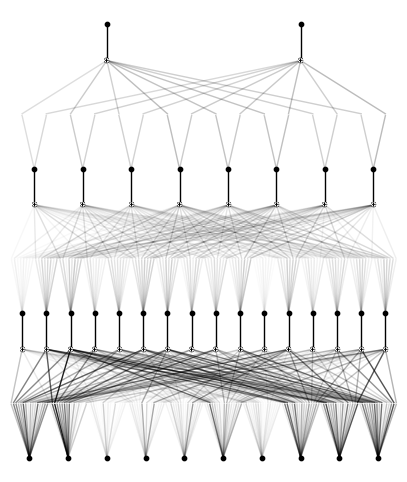

In [11]:
# ======================
# KAN VISUALIZATION
# ======================
model.kan.plot()


In [12]:


def plot_learned_function(model, X, feature_idx, n_points=200):
    model.eval()

    x_min = X[:, feature_idx].min()
    x_max = X[:, feature_idx].max()
    x_vals = torch.linspace(x_min, x_max, n_points)

    X_base = X.mean(dim=0).repeat(n_points, 1)
    X_base[:, feature_idx] = x_vals

    with torch.no_grad():
        y_vals = model(X_base).squeeze()

    return x_vals.cpu().numpy(), y_vals.cpu().numpy()


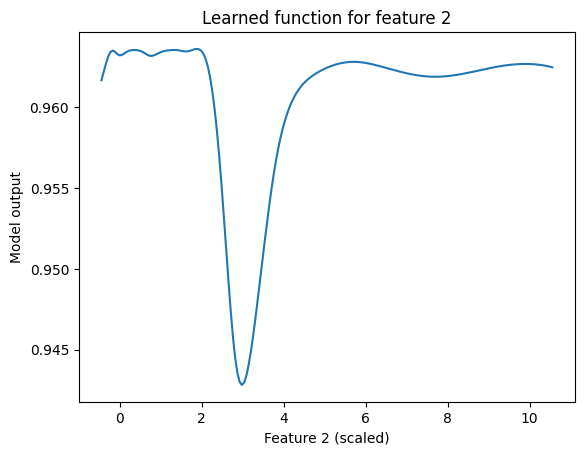

In [13]:
x, y = plot_learned_function(model, X_train, feature_idx=2)

plt.plot(x, y)
plt.xlabel("Feature 2 (scaled)")
plt.ylabel("Model output")
plt.title("Learned function for feature 2")
plt.show()


### Importance sensitivity 

In [14]:
def kan_feature_importance_sensitivity(model, X, eps=1e-2):
    model.eval()
    base_output = model(X).detach()

    input_dim = X.shape[1]
    importance = torch.zeros(input_dim)

    for i in range(input_dim):
        X_perturbed = X.clone()
        X_perturbed[:, i] += eps

        pert_output = model(X_perturbed).detach()
        importance[i] = torch.mean(torch.abs(pert_output - base_output))

    importance = importance / importance.sum()
    return importance
importance = kan_feature_importance_sensitivity(
    model,
    X_train
)

for name, score in zip(X_train_df.columns, importance):
    print(f"{name}: {score:.3f}")


Age: 0.140
Gender: 0.035
TB: 0.078
DB: 0.109
Alkphos: 0.076
Sgpt: 0.104
Sgot: 0.055
TP: 0.134
ALB: 0.166
A/G: 0.104


In [15]:
# ============================
# SIMPLIFY KAN (PRUNING)
# ============================
pruned_model = HybridKANQuantumModel(X_train.shape[1])
pruned_model.load_state_dict(best_state)
pruned_model.eval()

with torch.no_grad():
    _ = pruned_model(X_train)
pruned_model.kan.prune()
pruned_model.kan.plot()

plt.savefig(
    "kan_structure.png",
    dpi=1000,                 # chuẩn thesis / paper
    bbox_inches="tight"
)
plt.close()

checkpoint directory created: ./model
saving model version 0.0
saving model version 0.1


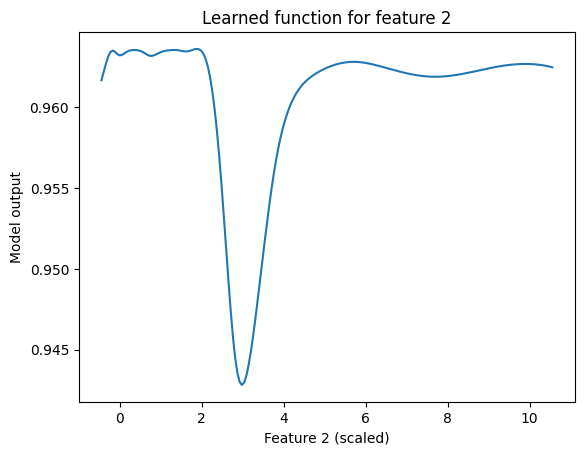

In [16]:
x, y = plot_learned_function(model, X_train, feature_idx=2)

plt.plot(x, y)
plt.xlabel("Feature 2 (scaled)")
plt.ylabel("Model output")
plt.title("Learned function for feature 2")
plt.show()
